## Chapter 7: Nonlinear Models ###

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import chi2
from sklearn.cluster import MeanShift
from scipy.interpolate import LSQUnivariateSpline
%matplotlib inline

In [2]:
# Data comes from ISLR::Wage - written using write.csv(Wage, "wage.csv", row.names=FALSE)
wage_df = pd.read_csv("../data/Wage.csv")
wage_df.head()

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,1. Male,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,1. Male,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


In [3]:
# factorize non-numeric variables
wage_df["sex"] = pd.factorize(wage_df["sex"])[0]
wage_df["maritl"] = pd.factorize(wage_df["maritl"])[0]
wage_df["race"] = pd.factorize(wage_df["race"])[0]
wage_df["education"] = pd.factorize(wage_df["education"])[0]
wage_df["region"] = pd.factorize(wage_df["region"])[0]
wage_df["health"] = pd.factorize(wage_df["health"])[0]
wage_df["health_ins"] = pd.factorize(wage_df["health_ins"])[0]
wage_df.head()

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,0,0,0,0,0,1. Industrial,0,0,4.318063,75.043154
1,2004,24,0,0,0,1,0,2. Information,1,0,4.255273,70.476020
2,2003,45,0,1,0,2,0,1. Industrial,0,1,4.875061,130.982177
3,2003,43,0,1,1,1,0,2. Information,1,1,5.041393,154.685293
4,2005,50,0,2,0,3,0,2. Information,0,1,4.318063,75.043154


### Polynomials ###

We attempt to build a model to predict wage given a degree 4 polynomial over age. In R the polynomial features are created using the poly() function. As pointed out in [this post from Dave Moore](http://davmre.github.io/python/2013/12/15/orthogonal_poly/) the method creates orthogonal polynomial features, which are different from simple powers of the original feature. Code for the poly() function shown below is a straight copy from the ortho_poly_fit() function code from this page.

In [4]:
def poly(x, degree = 1):
    n = degree + 1
    x = np.asarray(x).flatten()
    if(degree >= len(np.unique(x))):
        print("'degree' must be less than number of unique points")
        return
    xbar = np.mean(x)
    x = x - xbar
    X = np.fliplr(np.vander(x, n))
    q, r = np.linalg.qr(X)

    z = np.diag(np.diag(r))
    raw = np.dot(q, z)
    
    norm2 = np.sum(raw ** 2, axis=0)
    alpha = (np.sum((raw ** 2) * np.reshape(x,(-1,1)), axis=0) / norm2 + xbar)[:degree]
    Z = raw / np.sqrt(norm2)
    return Z, norm2, alpha

X = poly(wage_df["age"].values, 4)[0]
X[0:5, 1:]

array([[-0.0386248 ,  0.05590873, -0.07174058,  0.08672985],
       [-0.0291326 ,  0.02629807, -0.01454995, -0.00259928],
       [ 0.00409008, -0.01450655, -0.00013318,  0.01448009],
       [ 0.00092602, -0.0148314 ,  0.00451367,  0.01265751],
       [ 0.01200024, -0.00981585, -0.01113663,  0.01021146]])

Intercepts: -6287691075.27
Coefficients: [  3.44391030e+11   4.47067854e+02  -4.78315807e+02   1.25521688e+02
  -7.79111830e+01]


//anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


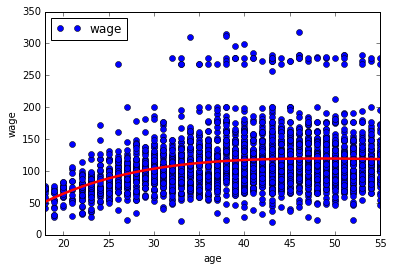

In [5]:
y = wage_df["wage"].values
reg = LinearRegression()
reg.fit(X, y)
print "Intercepts:", reg.intercept_
print "Coefficients:", reg.coef_
ax = wage_df.plot(x="age", y="wage", style="o")
ax.set_ylabel("wage")
# The poly() method cannot return features for a single X value, so we have
# to plot the raw predictions.
age = wage_df["age"].values
ypred = reg.predict(X)
polyline = np.poly1d(np.polyfit(age, ypred, 4))
xs = range(int(np.min(age)), int(np.max(age)))
ys = polyline(xs) 
ax.plot(xs, ys, 'r', linewidth=2.5)

We can repeat this experiment with manually calculated powers of the age feature as follows. Even though the parameters are different, the resulting linear model appears to be the same.

In [6]:
x1 = wage_df["age"].values
x2 = np.power(x1, 2)
x3 = np.power(x1, 3)
x4 = np.power(x1, 4)
X = np.vstack((x1, x2, x3, x4)).T
X[0:5, :]

array([[     18,     324,    5832,  104976],
       [     24,     576,   13824,  331776],
       [     45,    2025,   91125, 4100625],
       [     43,    1849,   79507, 3418801],
       [     50,    2500,  125000, 6250000]])

Intercepts: -184.154179774
Coefficients: [  2.12455205e+01  -5.63859313e-01   6.81068771e-03  -3.20383037e-05]


//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
//anaconda

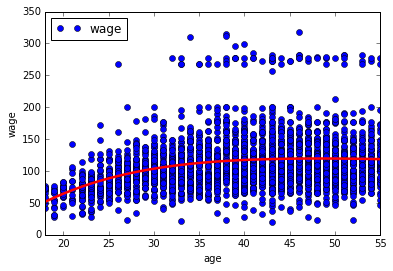

In [7]:
y = wage_df["wage"].values
reg = LinearRegression()
reg.fit(X, y)
print "Intercepts:", reg.intercept_
print "Coefficients:", reg.coef_
ax = wage_df.plot(x="age", y="wage", style="o")
ax.set_ylabel("wage")
xs = range(int(np.min(x1)), int(np.max(x1)))
ys = [reg.predict([x, x**2, x**3, x**4]) for x in xs]
ax.plot(xs, ys, 'r', linewidth=2.5)

R's summary() function applied to a linear model returns p-values for each coefficient, which enables one to guage the significance of each feature. Scikit-Learn does not provide anything similar, but it does provide methods for feature selection which provides p-values and scores. Based on p-values and scores below, it appears that the 4th degree feature is the least important of the four. However, R reports a p-value of 0.05 for the 4th power.

In [9]:
selector = SelectKBest(score_func=f_regression, k='all')
selector.fit(X, y)
(selector.scores_, selector.pvalues_)

(array([ 119.31172277,   77.71495649,   46.35938463,   25.11432639]),
 array([  2.90077768e-27,   1.97798773e-18,   1.18437983e-11,
          5.71655064e-07]))

The p-values observed from a linear model's summary() output only works as an indicator of feature importance if a single feature is being used. For multiple features, R advises the use of ANOVA. It turns out that the SelectKBest feature selector is [based on ANOVA](http://scikit-learn.org/stable/auto_examples/feature_selection_pipeline.html). The R example manually built models based on different feature sets then applied ANOVA to the models - there is no direct analog to that here.

### Polynomial Logistic Regression ###

Fitting a Logistic Regression model to a binary response variable. The response variable is "high-earners" where the salary > 250K.

Intercepts: [-0.00721825]
Coefficients: [[ -9.77916678e-02  -8.45456184e-04   2.46527805e-05]]
MSE: 0.0263333333333


//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)
//anaconda

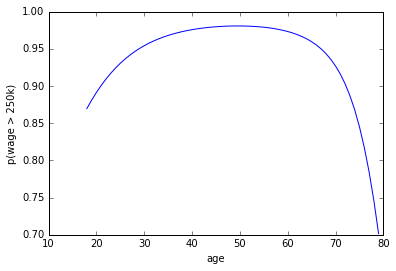

In [10]:
X = np.vstack((x1, x2, x3)).T
y = wage_df["wage"].map(lambda w: 1 if w > 250 else 0).values
reg = LogisticRegression()
reg.fit(X, y)
print "Intercepts:", reg.intercept_
print "Coefficients:", reg.coef_
ypred = reg.predict(X)
print "MSE:", mean_squared_error(y, ypred)

# Plot the predicted probability of being a high-earner over age range
ages = wage_df["age"].values
xs = range(np.min(ages), np.max(ages))
ys = [reg.predict_proba(np.array([x, x*x, x*x*x]))[0][0] for x in xs]
plt.plot(xs, ys)
plt.xlabel("age")
plt.ylabel("p(wage > 250k)")

### Splines ###

Splines is a curve approximated by a series of straight lines. The breaks in the straight lines are called knots. The idea is to fit multiple linear models to these ranges, one each for each straight line segment. Scipy offers the UnivariateSpline but it requires manual knot selection. The code snippet below uses Mean-Shift clustering to automatically derive the knots based on this [thread on StackOverflow](http://stackoverflow.com/questions/8719754/scipy-interpolate-univariatespline-not-smoothing-regardless-of-parameters).

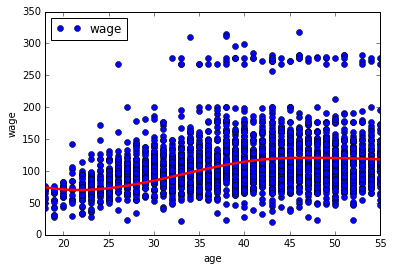

In [11]:
ages = wage_df["age"].values
wages = wage_df["wage"].values
X = np.vstack((ages, wages)).T
# cluster points to find the knot location
msc = MeanShift()
msc.fit(X)
knots = msc.cluster_centers_[:, 0]

# fit a spline over the points
spl = LSQUnivariateSpline(ages, wages, knots)
xs = range(np.min(ages), np.max(ages))
ys = spl(xs)

# plot the points and the spline
ax = wage_df.plot(x="age", y="wage", style="o")
ax.set_ylabel("wage")
ax.plot(xs, ys, 'r', linewidth=2.5)

### Generalized Additive Models ###

Generalized Additive Models are not yet available under Scikit-Learn. It was one of the projects proposed for GSoC 2014 but as far as I know it did not get approved. StatsModel has an untested implementation. Since it is not available in Python, I decided to skip it for now.